In [21]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
import mlflow

np.set_printoptions(precision=3, suppress=True)
tf.__version__

'2.4.1'

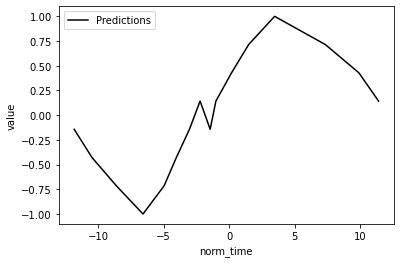

In [22]:
# Read dataset from file
raw_dataset = pd.read_csv("./data_grouped/1160622000_111_.csv")
raw_dataset = raw_dataset.astype({'id':'float','value':'float', 'station_id':'int', 'parameter_id':'int', 'unix_timestamp':'int', 'norm_time':'float'})
dataset = raw_dataset.copy()
dataset = dataset.dropna().drop(['id','station_id','parameter_id','unix_timestamp'], axis=1)
dataset_full = dataset.sort_values(by=['norm_time'])
dataset = dataset_full[0:300]

plt.plot(dataset['norm_time'], dataset['norm_value'], color='k', label='Predictions')
plt.xlabel('norm_time')
plt.ylabel('value')
plt.legend()
plt.show()

In [23]:
test_file_name = "./data_grouped/1160622000_115_.csv"
test_raw_dataset = pd.read_csv(test_file_name)
test_raw_dataset = test_raw_dataset.astype({'id':'float','value':'float', 'station_id':'int', 'parameter_id':'int', 'unix_timestamp':'int', 'norm_time':'float'})
test_dataset = test_raw_dataset.copy()
test_dataset = test_dataset.dropna().drop(['id','station_id','parameter_id','unix_timestamp'], axis=1)
test_dataset_full = test_dataset.sort_values(by=['norm_time'])
start_line = 0
end_line = 44
test_data = test_dataset_full[start_line:end_line]

In [24]:
serial_data = dataset.drop(['value','norm_time'], axis=1)
serial_data['norm_1'] = serial_data['norm_value'].shift(1)
serial_data['norm_2'] = serial_data['norm_value'].shift(2)
serial_data['norm_3'] = serial_data['norm_value'].shift(3)
serial_data['norm_4'] = serial_data['norm_value'].shift(4)
serial_data['norm_5'] = serial_data['norm_value'].shift(5)
serial_data['norm_6'] = serial_data['norm_value'].shift(6)
serial_data = serial_data[6:]
serial_data

,norm_value,norm_1,norm_2,norm_3,norm_4,norm_5,norm_6
6,-0.142857,-0.428571,-0.714286,-1.000000,-0.714286,-0.428571,-0.142857
7,0.142857,-0.142857,-0.428571,-0.714286,-1.000000,-0.714286,-0.428571
8,-0.142857,0.142857,-0.142857,-0.428571,-0.714286,-1.000000,-0.714286
9,0.142857,-0.142857,0.142857,-0.142857,-0.428571,-0.714286,-1.000000
10,0.428571,0.142857,-0.142857,0.142857,-0.142857,-0.428571,-0.714286
11,0.714286,0.428571,0.142857,-0.142857,0.142857,-0.142857,-0.428571
12,1.000000,0.714286,0.428571,0.142857,-0.142857,0.142857,-0.142857
13,0.714286,1.000000,0.714286,0.428571,0.142857,-0.142857,0.142857
14,0.428571,0.714286,1.000000,0.714286,0.428571,0.142857,-0.142857
15,0.142857,0.428571,0.714286,1.000000,0.714286,0.428571,0.142857


In [25]:
test_serial_data = test_data.drop(['value','norm_time'], axis=1)
test_serial_data['norm_1'] = test_serial_data['norm_value'].shift(1)
test_serial_data['norm_2'] = test_serial_data['norm_value'].shift(2)
test_serial_data['norm_3'] = test_serial_data['norm_value'].shift(3)
test_serial_data['norm_4'] = test_serial_data['norm_value'].shift(4)
test_serial_data['norm_5'] = test_serial_data['norm_value'].shift(5)
test_serial_data['norm_6'] = test_serial_data['norm_value'].shift(6)
test_serial_data = test_serial_data[6:]
test_serial_data

,norm_value,norm_1,norm_2,norm_3,norm_4,norm_5,norm_6
6,-0.126618,-0.229038,-0.126618,-0.229038,-0.126618,-0.229038,-0.331458
7,-0.229038,-0.126618,-0.229038,-0.126618,-0.229038,-0.126618,-0.229038
8,-0.126618,-0.229038,-0.126618,-0.229038,-0.126618,-0.229038,-0.126618
9,-0.229038,-0.126618,-0.229038,-0.126618,-0.229038,-0.126618,-0.229038
10,-0.126618,-0.229038,-0.126618,-0.229038,-0.126618,-0.229038,-0.126618
11,-0.229038,-0.126618,-0.229038,-0.126618,-0.229038,-0.126618,-0.229038
12,-0.126618,-0.229038,-0.126618,-0.229038,-0.126618,-0.229038,-0.126618
13,-0.229038,-0.126618,-0.229038,-0.126618,-0.229038,-0.126618,-0.229038
14,-0.126618,-0.229038,-0.126618,-0.229038,-0.126618,-0.229038,-0.126618
15,-0.229038,-0.126618,-0.229038,-0.126618,-0.229038,-0.126618,-0.229038


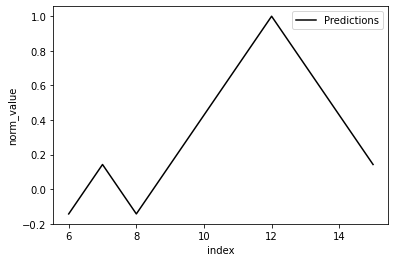

In [26]:
plt.plot(serial_data.index, serial_data['norm_value'], color='k', label='Predictions')
plt.xlabel('index')
plt.ylabel('norm_value')
plt.legend()
plt.show()

In [27]:
train_dataset = serial_data
test_dataset = test_serial_data

In [28]:
train_features = np.array(train_dataset.drop(['norm_value'], axis=1))
train_features = np.array(train_features)[:,:,np.newaxis]
train_features.shape

(10, 6, 1)

In [29]:
train_labels = np.array(train_dataset.drop(['norm_6'], axis=1))
train_labels = train_labels.reshape(train_labels.shape[0],train_labels.shape[1],1)
train_labels.shape

(10, 6, 1)

In [30]:
test_features = np.array(test_dataset.drop(['norm_value'], axis=1))
test_features = test_features.reshape(test_features.shape[0],test_features.shape[1],1)
test_features.shape

(38, 6, 1)

In [31]:
test_labels = np.array(test_dataset.drop(['norm_6'], axis=1))
test_labels = test_labels.reshape(test_labels.shape[0],test_labels.shape[1],1)
test_labels.shape

(38, 6, 1)

In [32]:
model = keras.Sequential()
model.add(layers.LSTM(32, return_sequences=True))
model.add(layers.LSTM(32, return_sequences=True))
model.add(layers.TimeDistributed(layers.Dense(1)))
model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(0.005))
model.fit(train_features, train_labels, epochs=200, batch_size=1, verbose=2)


Epoch 1/200
10/10 - 4s - loss: 0.1892
Epoch 2/200
10/10 - 0s - loss: 0.1443
Epoch 3/200
10/10 - 0s - loss: 0.1121
Epoch 4/200
10/10 - 0s - loss: 0.0709
Epoch 5/200
10/10 - 0s - loss: 0.0447
Epoch 6/200
10/10 - 0s - loss: 0.0345
Epoch 7/200
10/10 - 0s - loss: 0.0296
Epoch 8/200
10/10 - 0s - loss: 0.0265
Epoch 9/200
10/10 - 0s - loss: 0.0239
Epoch 10/200
10/10 - 0s - loss: 0.0231
Epoch 11/200
10/10 - 0s - loss: 0.0224
Epoch 12/200
10/10 - 0s - loss: 0.0220
Epoch 13/200
10/10 - 0s - loss: 0.0212
Epoch 14/200
10/10 - 0s - loss: 0.0214
Epoch 15/200
10/10 - 0s - loss: 0.0213
Epoch 16/200
10/10 - 0s - loss: 0.0215
Epoch 17/200
10/10 - 0s - loss: 0.0216
Epoch 18/200
10/10 - 0s - loss: 0.0211
Epoch 19/200
10/10 - 0s - loss: 0.0209
Epoch 20/200
10/10 - 0s - loss: 0.0202
Epoch 21/200
10/10 - 0s - loss: 0.0200
Epoch 22/200
10/10 - 0s - loss: 0.0200
Epoch 23/200
10/10 - 0s - loss: 0.0206
Epoch 24/200
10/10 - 0s - loss: 0.0207
Epoch 25/200
10/10 - 0s - loss: 0.0198
Epoch 26/200
10/10 - 0s - loss: 0.

MSE 0.05554861514087234


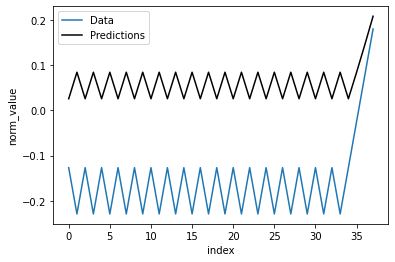

In [33]:
from sklearn.metrics import mean_squared_error

with mlflow.start_run():

    result = model.predict(test_features, batch_size=1, verbose=0)

    x=pd.DataFrame(test_labels.reshape(test_labels.shape[0],test_labels.shape[1]))
    y=pd.DataFrame(result.reshape(result.shape[0],result.shape[1]))
    y_true = np.array(x[0])
    y_pred = np.array(y[0])
    
    mse = mean_squared_error(y_true, y_pred)
    print("MSE", mse)
    
    mlflow.log_metric("MSE",mse)
    mlflow.log_param("test line from ", '{} {}'.format(start_line, end_line))
    mlflow.log_param("Test file", test_file_name)
    plt.plot(x.index, x[0], label='Data')
    plt.plot(y.index, y[0], color='k', label='Predictions')
    plt.xlabel('index')
    plt.ylabel('norm_value')
    plt.legend()
    plt.savefig("BTS_resultGraph.png")
    mlflow.log_artifact("BTS_resultGraph.png")
    plt.show()
    plt.close()

In [34]:
# => data line 200 den 250 lech => 800 den 850
# 950-1150